In [2]:
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt

import numpy as np
import json

In [3]:
load_dotenv()
environ = os.environ


In [4]:
SOURCE1_DIR = environ.get('SOURCE1_DIR')
classes_dirs = [el for el in os.listdir(SOURCE1_DIR) if os.path.isdir(os.path.join(SOURCE1_DIR, el))]
all_images = {}
training_images = {}

for class_dir in classes_dirs:
      subdirs = [el for el in os.listdir(os.path.join(SOURCE1_DIR, class_dir)) if os.path.isdir(os.path.join(SOURCE1_DIR, class_dir, el))]
      for subdir in subdirs:
        full_dirpath = os.path.join(SOURCE1_DIR, class_dir, subdir)
        
        if "train" in str(subdir):
            if class_dir in training_images:
                training_images[class_dir].extend([os.path.join(subdir, f) for f in os.listdir(full_dirpath)])
            else:
              training_images[class_dir] = [os.path.join(subdir, f) for f in os.listdir(full_dirpath)]
        else:
            if class_dir in all_images:
                all_images[class_dir].extend([os.path.join(subdir, f) for f in os.listdir(full_dirpath)])
            else:
                all_images[class_dir] = [os.path.join(subdir, f) for f in os.listdir(full_dirpath)]


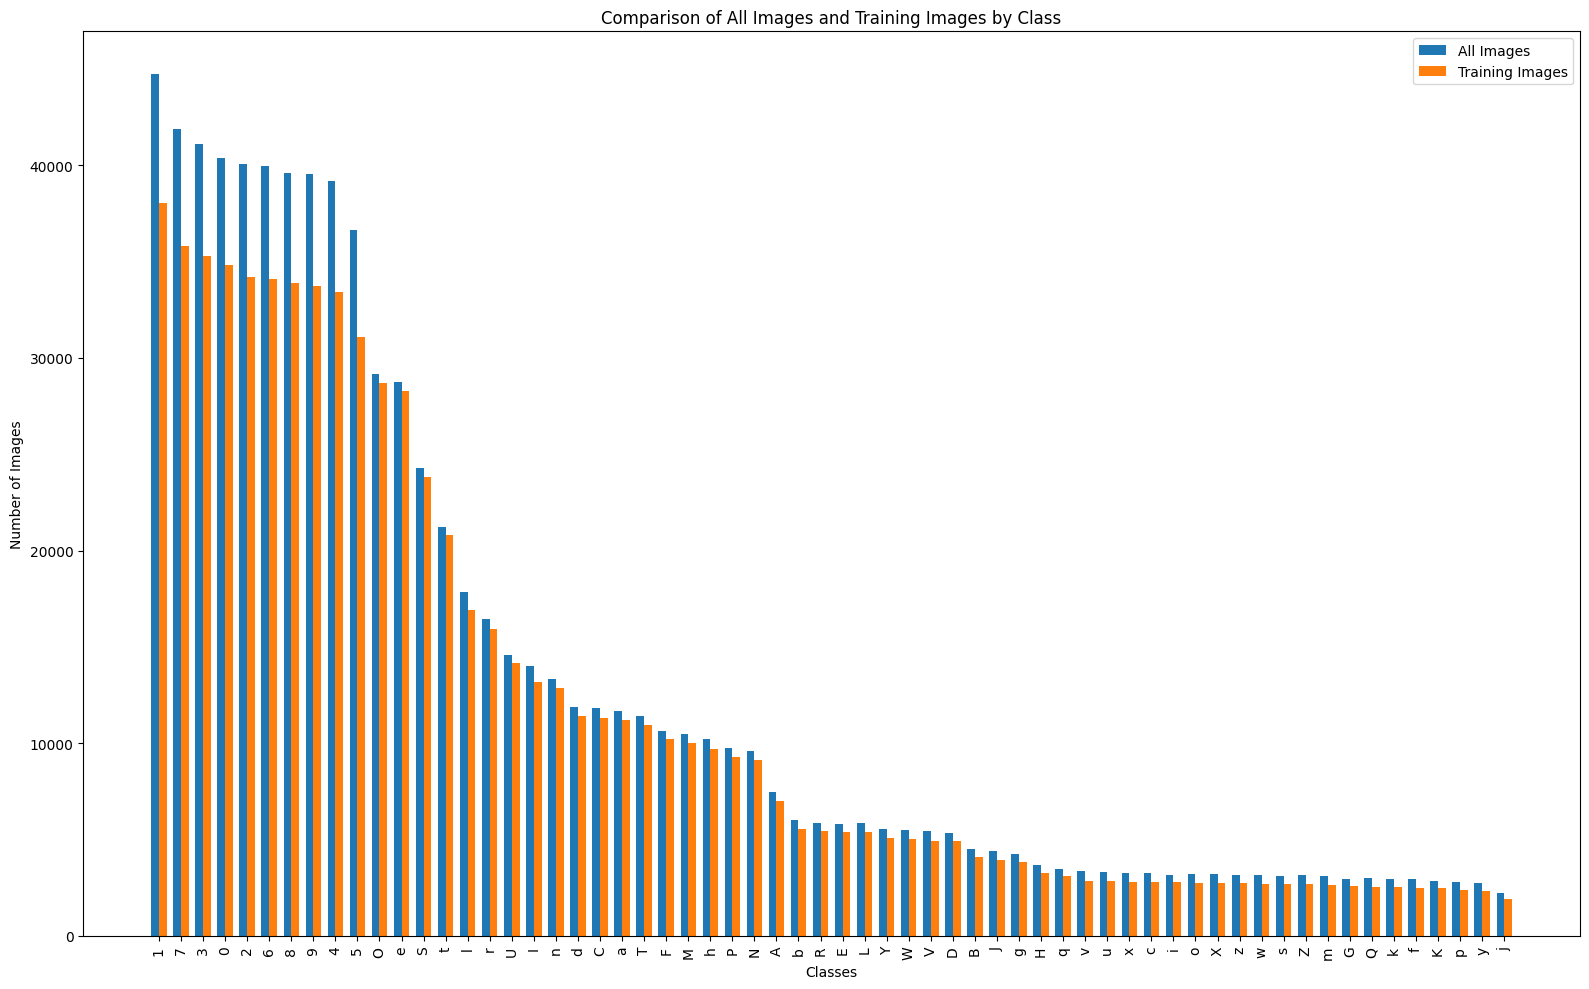

In [5]:
training_counts = [len(training_images[cs]) for cs in classes_dirs]
overall_counts = [len(all_images[cs]) for cs in classes_dirs]

data = list(zip(classes_dirs, training_counts, overall_counts))
data = sorted(data, key=lambda x: x[1], reverse=True)
classes_dirs, training_counts, overall_counts = zip(*data)

x = np.arange(len(classes_dirs))  
width = 0.35  

SOURCE1_MAPPINGS = {}
with open(environ.get('CLASS_MAPPINGS_JSON'), 'r') as m_f:
    SOURCE1_MAPPINGS = json.load(m_f)

SOURCE1_DIR_CLASS = [SOURCE1_MAPPINGS['SOURCE1']['mapping'][cs] for cs in classes_dirs]


fig, ax = plt.subplots(figsize=(16, 10))

bar1 = ax.bar(x - width/2, overall_counts, width, label='All Images')
bar2 = ax.bar(x + width/2, training_counts, width, label='Training Images')

ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Comparison of All Images and Training Images by Class')
ax.set_xticks(x)
ax.set_xticklabels(SOURCE1_DIR_CLASS, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()



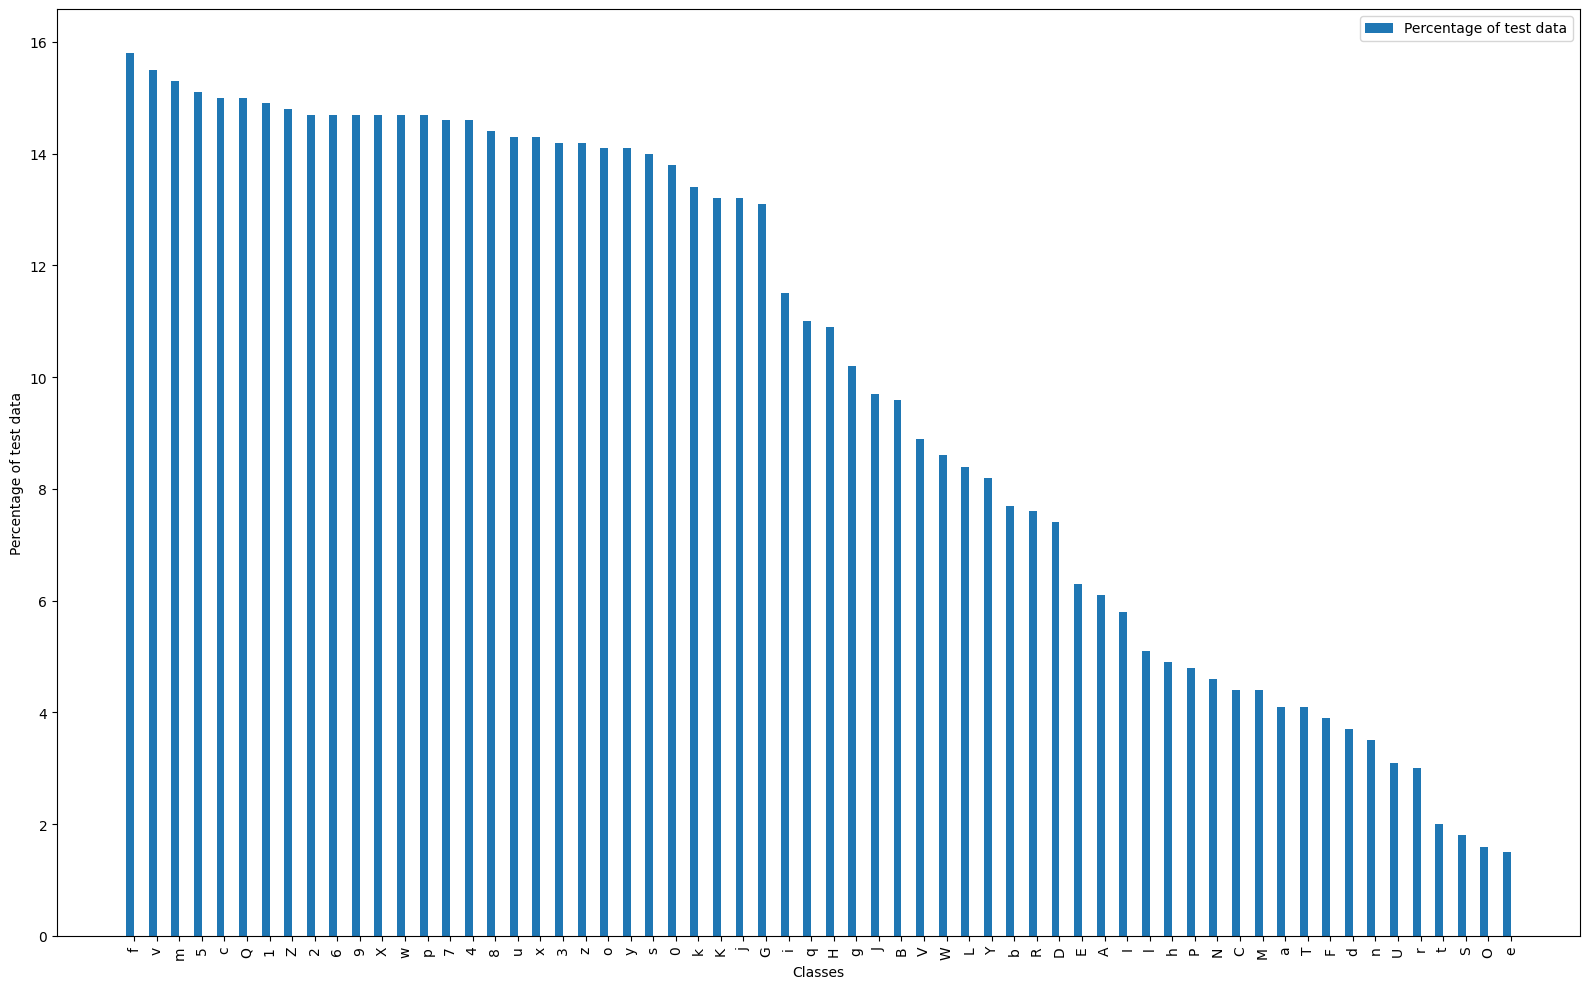

In [6]:
train_overall_proportions = []

for idx in range(len(training_counts)):
    train_overall_proportions.append(round(float(1) - training_counts[idx]/overall_counts[idx], ndigits=3)* 100)

data = list(zip(classes_dirs, train_overall_proportions))
data = sorted(data, key=lambda x: x[1], reverse=True)
classes_dirs, train_overall_proportions = zip(*data)


x = np.arange(len(classes_dirs))  
width = 0.35  

SOURCE1_MAPPINGS = {}
with open(environ.get('CLASS_MAPPINGS_JSON'), 'r') as m_f:
    SOURCE1_MAPPINGS = json.load(m_f)

SOURCE1_DIR_CLASS = [SOURCE1_MAPPINGS['SOURCE1']['mapping'][cs] for cs in classes_dirs]


fig, ax = plt.subplots(figsize=(16, 10))

bar1 = ax.bar(x - width/2, train_overall_proportions, width, label="Percentage of test data")

ax.set_xlabel('Classes')
ax.set_ylabel('Percentage of test data')
ax.set_xticks(x)
ax.set_xticklabels(SOURCE1_DIR_CLASS, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()



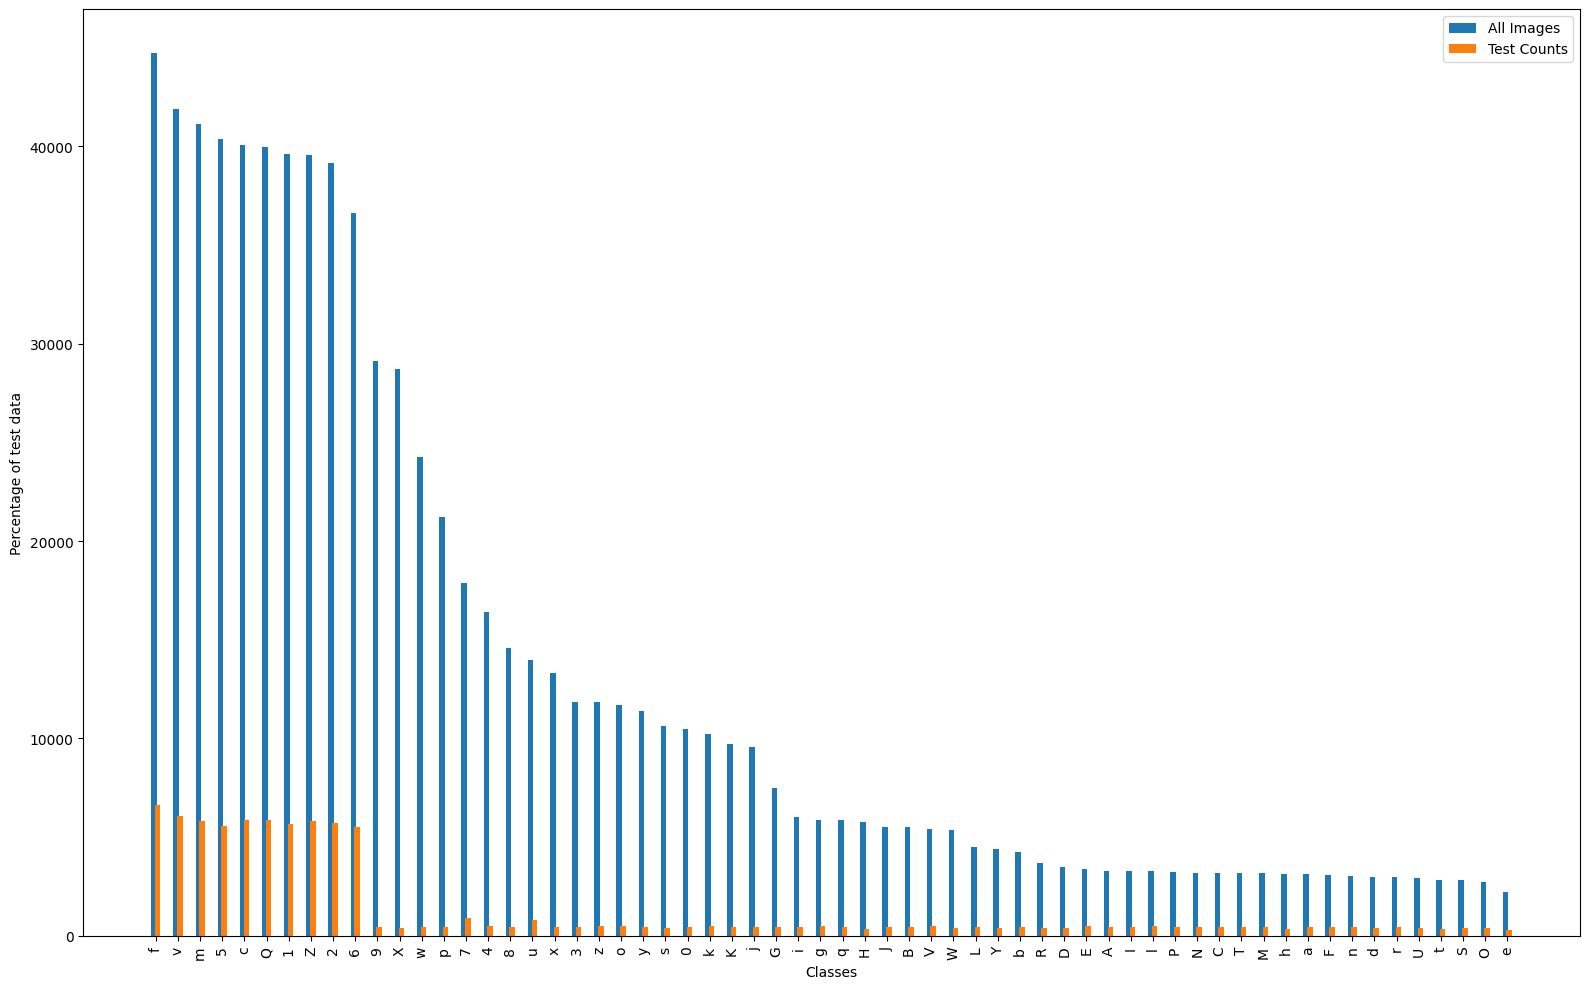

In [7]:
test_counts = []

for idx in range(len(training_counts)):
    test_counts.append(overall_counts[idx] - training_counts[idx])

data = list(zip(classes_dirs, overall_counts, test_counts, train_overall_proportions))
data = sorted(data, key=lambda x: x[1], reverse=True)
classes_dirs, overall_counts, test_counts, train_overall_proportions = zip(*data)


x = np.arange(len(classes_dirs))  
width = 0.25  

SOURCE1_MAPPINGS = {}
with open(environ.get('CLASS_MAPPINGS_JSON'), 'r') as m_f:
    SOURCE1_MAPPINGS = json.load(m_f)

SOURCE1_DIR_CLASS = [SOURCE1_MAPPINGS['SOURCE1']['mapping'][cs] for cs in classes_dirs]


fig, ax = plt.subplots(figsize=(16, 10))

bar1 = ax.bar(x - width/3, overall_counts, width, label='All Images')
bar2 = ax.bar(x + width/3, test_counts, width, label='Test Counts')

ax.set_xlabel('Classes')
ax.set_ylabel('Percentage of test data')
ax.set_xticks(x)
ax.set_xticklabels(SOURCE1_DIR_CLASS, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()



By analyzing these charts we understodd that dataset of symbols is highly inbalanced, there's not only big difference beetween amount of handwritten digits compared to letters, i currently don't see any trend about letter imbalance, it seems that percentages of train vs test data are inconsistent nor by amount nor by percentage from overall. I definitely goint to shuffle data and create custom data split, i don't really see a point to balance by oversampling because it's not really data that you can augment (hard augmentations) and fit as in most CV problems. I should check if i can populate, balance letters using some additional data.

In [ ]:
import shutil

SOURCE1_DEST_DIR = os.path.join(os.environ.get('STORAGE_PATH'), 'SOURCE1', 'by_class')
os.makedirs(SOURCE1_DEST_DIR, exist_ok=True)

for key, val in SOURCE1_MAPPINGS['SOURCE1']['mapping'].items():
    class_dest_dir = os.path.join(SOURCE1_DEST_DIR, val)
    os.makedirs(class_dest_dir, exist_ok=True)

SOURCE1_DIR = environ.get('SOURCE1_DIR')
classes_dirs = [el for el in os.listdir(SOURCE1_DIR) if os.path.isdir(os.path.join(SOURCE1_DIR, el))]

file_counters = {val: 0 for val in SOURCE1_MAPPINGS['SOURCE1']['mapping'].values()}

for class_dir in classes_dirs:
    subdirs = [el for el in os.listdir(os.path.join(SOURCE1_DIR, class_dir)) if os.path.isdir(os.path.join(SOURCE1_DIR, class_dir, el))]
    
    for subdir in subdirs:
        full_dirpath = os.path.join(SOURCE1_DIR, class_dir, subdir)
        
        if "train" in str(subdir):
            continue
        
        mapped_class = SOURCE1_MAPPINGS['SOURCE1']['mapping'].get(class_dir, None)
        if mapped_class:
            dest_dir = os.path.join(SOURCE1_DEST_DIR, mapped_class)
            
            for filename in os.listdir(full_dirpath):
                src_filepath = os.path.join(full_dirpath, filename)
                
                new_filename = f"{mapped_class}_{file_counters[mapped_class]:05d}.png"
                dest_filepath = os.path.join(dest_dir, new_filename)
                
                shutil.copy(src_filepath, dest_filepath)
                print(f"Copied {src_filepath} to {dest_filepath}")
                
                file_counters[mapped_class] += 1